<img src="https://s0.cptec.inpe.br/webcptec/sites/www/assets/img/logo_cptec.png" align="right" width="64"/>

# <div style="text-align: center;"><span style="color:#336699; font-size: 1.2em;">1º Love Data Day - BIG TechTalks:<br><span style="color:#336699; font-style: italic;">      Usando Dados de Temperatura e STAC Browser em Análise do "Dia do Fogo em SP"</span></span></div>
<hr style="border:2px solid #0077b9;">

<br/>

<div style="text-align: center;font-size: 90%;">
    Alex de Almeida Fernandes<sup><a href="https://orcid.org/0000-0003-1520-5896"><i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>
    <br/><br/>
    Divisão de Previsão de Tempo e Clima, Instituto Nacional de Pesquisas Espaciais (INPE)
    <br/>
    Rodovia Presidente Dutra, km 40, Cachoeira Paulista, SP 12630-000, Brazil
    <br/><br/>
    Contato: <a href="mailto:alex.fernandes@inpe.br">alex.fernandes@inpe.br</a>
    <br/><br/>
    Ultíma Atualização: 27 de Maio de 2025
</div>

<br/>

<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;">
<b>Resumo.</b> Este Jupyter Notebook é parte do BIG TechTalks, edição especial <i>Love Data Days</i> - Acesso, Visualização e Processamento de dados de temperatura diária do dado SAMeT produzido no INPE. O dado sAMeT consiste na combinação dos dados de superfície das estações em conformidade com o padrão da Organização Meteorológica Mundial e dados numéricos de temperatura. Esta combinação torna a estimativa de temperatura em pontos sem observações mais precisa e permite o uso em locais onde não há observações de superfície nas proximidades. Este Jupyter Notebook apresenta uma visão geral de como utilizar o serviço STAC na linguagem Python para descoberta e acesso aos produtos de dados de sensoriamento remoto disponíveis no catálogo do INPE, além de demonstrar a abertura de arquivos no formato NetCDF e como visualizar os dados de Temperatura.
<br/><br/>
</div>



# Dia do Fogo em SP - 23 de Agosto de 2024

No dia 23 de agosto de 2024 um evento chamou atenção pública pela ocorrência de diversos focos de fogo iniciando em horários próximos na região norte e oeste do estado de São Paulo.
A intenção deste notebook é demonstrar as _condições de fogo_ baseando-se na precipitação ocorrida até 3 meses antes. 

Os dados de precipitação utilizados será a base do SAMeT/INPE, que combina dados observados em superfície com dados numéricos e interpolações, fornecendo um dado mais preciso do que a simples interpolação ou dados de reanálise.

A Temperatura do perído de 2024 será comparada com a média de longo termo iniciada em 2000, dete modo, teremos uma comparação da temperatura média em 24 anos e no perído de ocorrência do evento. Será que a temperatura pode ter ajudado os incêndios neste período?

Vamos olhar os dados... De novo...

In [3]:
%pip install xarray cfgrib netcdf4
%pip install cartopy
%pip install geopandas
%pip install regionmask
%pip install rioxarray

%reset -f

Note: you may need to restart the kernel to use updated packages.
  Using cached cartopy-0.25.0-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.1 kB)
  Using cached pyshp-3.0.2.post1-py3-none-any.whl.metadata (64 kB)
  Using cached contourpy-1.3.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.3 kB)
Using cached cartopy-0.25.0-cp310-cp310-macosx_10_9_x86_64.whl (11.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 8.1 MB/s  0:00:016m0:00:0100:01
Using cached contourpy-1.3.2-cp310-cp310-macosx_10_9_x86_64.whl (268 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.3 MB/s  0:00:00m eta 0:00:01
Using cached kiwisolver-1.4.9-cp310-cp310-macosx_10_9_x86_64.whl (66 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 8.4 MB/s  0:00:006m0:00:0100:01
Using cached pyshp-

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
import pystac_client
import pystac
import itertools
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
from dateutil.parser import parse
import rioxarray  # necessário para clipping com shapefile
import geopandas as gpd
import zipfile



import warnings
warnings.filterwarnings("ignore")

import os
os.environ['PROJ_LIB'] = "/opt/conda/envs/geospatial/share/proj"


## 1. Serviço STAC e Coleções

Notebook de demonstração de acesso ao catálogo e da coleção de interesse, neste caso o SAMeT com acumulado diário de precipitação em formato _NetCDF_.

Boa parte dos produtos de imagem disponibilizados no catálogo de imagens do INPE são disponibilizados de maneira aberta na forma de arquivos otimizados para cloud, o denominado formato Cloud Optimized GeoTIFF (COG). Este formato permite que as aplicações possam utilizar as imagens através da Web com o melhor compromisso possível, incluindo o uso de pirâmide de multi-resolução para aplicações de visualização ou até mesmo a recuperação parcial de porções de uma imagem. O COG e o serviço de análise da BIG/INPE permite várias análises e fecilidades com tal formato, que não será o caso deste notebook. 

Os produtos de dados podem ser consultados utilizando uma interface de programação de aplicações baseada no padrão aberto SpatioTemporal Asset Catalog (STAC). Esta especificação, criada por organizações e especialistas do setor geoespaciall.

Em que:

- **Catalog**: É um tipo de objeto que fornece uma estrutura para vincular vários itens ou coleções STAC juntos ou mesmo outros catálogos. Na figura acima, o catálogo é composto de três coleções: Landsat/OLI, CBERS4/WFI e Sentinel-2/MSI.

- **Collection:** É uma especialização do catálogo que permite incluir informações adicionais sobre uma determinada coleção espaço-temporal. Uma coleção pode conter informações como o conjunto de bandas espectrais disponíveis das imagens, a extensão geográfica ou área de cobertura das imagens, o período de tempo que compreende a coleção, entre outras informações. Em geral, através da coleção chegamos aos itens dessa coleção.

- **Item**: Corresponde à unidade atômica de metadados, fornecendo *links* para os *assets* associados. Um *Item* é descrito através da notação GeoJSON, como uma feição (*feature*) contendo atributos específicos como a coleção a que ele pertence, propriedades temporais, *links* para os *assets* e coleções ou catálogos associados. Na figura acima, um `Item` equivale a uma cena obtida por um satélite em um determinado instante de tempo.

- **Asset**: Um *asset* é qualquer recurso geoespacial, como um arquivo de imagem ou arquivo vetorial, contendo informações sobre a supefície da Terra, em um determinado espaço e tempo.


A especificação conceitual do STAC permite dois tipos de implementações:

- **STAC estático:** Baseada em um conjunto de documentos JSON ligados que podem ser facilmente navegados. Ex: [CBERS na AWS](https://cbers-stac-1-0-0.s3.amazonaws.com/CBERS4/catalog.json).

- **STAC dinâmico:** Baseada em uma API RESTful, de modo que a navegação é realizada através de uma API de serviço web que permite realizar consultas utilizando uma linguagem padrão para acessar subconjuntos do catálogo. Ex: [BDC-STAC](https://data.inpe.br/bdc/stac/v1).


<br/>
<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;font-size: 75%; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 5px;">
    <b>Nota:</b> Como parte do aperfeiçoamento dos produtos e serviços disponibilizados pelo INPE à sociedade, encontra-se em desenvolvimento o novo portal <a href="https://data.inpe.br/">https://data.inpe.br/</a>, que faz parte da modernização da infraestrutura de serviços para acesso às imagens de satélites do acervo do instituto. Esse portal foi criado com o intuito de facilitar a pesquisa e obtenção das imagens disponibilizadas gratuitamente. Esse novo serviço tem como base as tecnologias desenvolvidas no projeto Brazil Data Cube, e está ancorado dentro do Programa Base de Informações Georreferenciadas (BIG) do INPE. Para navegar pelas coleções disponibilizadas no serviço STAC do INPE, utilize a instância do [STAC Browser](https://data.inpe.br/stac/browser/).
</div>



In [5]:
#PySTAC
service = pystac_client.Client.open('https://data.inpe.br/bdc/stac/v1/')
service

for colecao in service.get_collections():
    print(f"{colecao.id}: {colecao.title}", end="\n"*2)

sentinel-3-olci-l1-bundle-1: Sentinel-3/OLCI - Level-1B Full Resolution

GOES19-L2-CMI-1: GOES-19 Cloud & Moisture Imagery

mosaic-cbers4a-paraiba-3m-1: CBERS-4A/WFI 3M Paraíba State Mosaic

LCC_L8_30_16D_STK_Cerrado-1: LCC - Cerrado - LC8 30m 16D STK

mosaic-landsat-sp-6m-1: Landsat 6M São Paulo State Mosaic

CB2B-CCD-L2-DN-1: CBERS-2B/CCD - Level-2-DN

CB4-WFI-L4-SR-1: CBERS-4/WFI - Level-4-SR - Cloud Optimized GeoTIFF

mosaic-s2-paraiba-3m-1: S2 3M Paraiba State Mosaic

LCC_L8_30_16D_STK_MataAtlantica-1: LCC - Mata Atlantica - LC8 30m 16D STK

mosaic-s2-yanomami_territory-6m-1: S2 6M Yanomami Indigenous Territory Mosaic

LANDSAT-16D-1: Landsat Collection 2 - Level-2 - Data Cube - LCF 16 days

LCC_L8_30_16D_STK_Pantanal-1: LCC - Pantanal - LC8 30m 16D STK

LCC_L8_30_1M_STK_Cerrado-1: LCC - Cerrado - LC8 30m 1M STK

MODISA-OCSMART-RRS-MONTHLY-1: MODIS-Aqua Monthly Rrs - OC-SMART AC

mosaic-s2-brazil-3m-1: S2 3M Mosaic

S2_L2A-1: Sentinel-2 - Level-2A - Cloud Optimized GeoTIFF

CB4-PAN

In [6]:
collection = service.get_collection('samet_daily-1')
collection

<CollectionClient id=samet_daily-1>

In [8]:
#collection.item_assets['tmax']
import itertools

item_search = service.search(
    collections=['samet_daily-1'],
    datetime='2024-08-01/2024-09-01'
)

print ("quantidade de itens:", item_search.matched())

samet_list = []
for i, item in enumerate(item_search.items()):
    print(i, item.assets['tmax'].href, sep='\t')
    samet_list.append(item.assets['tmax'].href)


quantidade de itens: 32
0	https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/09/SAMeT_CPTEC_TMAX_20240901.nc
1	https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240831.nc
2	https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240830.nc
3	https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240829.nc
4	https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240828.nc
5	https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240827.nc
6	https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240826.nc
7	https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240825.nc
8	https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240824.nc
9	https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240823.nc
10	https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240822.nc
11	https://data.inpe.br/bdc/d

In [9]:
def download_and_read_samet_stac(
    stac_service: str,
    start_date: str,
    end_date: str,
    collection: str,
    var: str,
    output_dir: str = "samet_data"
):
    """
    Busca, baixa e lê dados SAMeT em formato NETCDF de um catálogo STAC,
    filtrando por um período de datas.

    Args:
        stac_catalog_url (str): URL do catálogo/item STAC.
        start_date (str): Data inicial (formato ISO ou legível, ex: '2024-01-01').
        end_date (str): Data final (formato ISO ou legível, ex: '2024-01-31').
        output_dir (str): Pasta onde salvar os arquivos baixados.

    Returns:
        ds (xarray.Dataset): Dataset contendo os dados lidos.
    """
    # Converte datas para objetos datetime
    start_dt = parse(start_date)
    end_dt = parse(end_date)

    # Cria diretório de saída se não existir
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    downloaded_files = []

    if isinstance(service, pystac.Catalog) and stac_service.id == 'INPE':
        item_search = service.search(datetime=start_date+'/'+end_date,
                             collections=[collection])
        for asset in item_search.items():
            if asset.assets[var].href.endswith(".nc"):
                file_url = asset.assets[var].href
                filename = Path(file_url).name
                file_path = output_path / filename
                #print (grib_date)

                print(f"Baixando: {file_url}")
                response = requests.get(file_url, stream=True)
                response.raise_for_status()

                with open(file_path, "wb") as f:
                    for chunk in response.iter_content(chunk_size=1024 * 1024):
                        if chunk:
                            f.write(chunk)

                        #print(f"Arquivo salvo: {file_path}")
                        downloaded_files.append(file_path)
    else:
        raise ValueError("STAC URL deve apontar para um Catálogo ou Item.")

    # Verifica se algum arquivo foi baixado
    if not downloaded_files:
        raise FileNotFoundError("Nenhum arquivo .nc foi encontrado no período especificado.")

    # Lê os arquivos com xarray
    print("Lendo arquivos com xarray...")
          
    # Lê múltiplos arquivos com open_mfdataset, aplicando a função preprocess
    ds = xr.open_mfdataset(
        downloaded_files,
        combine='by_coords')
    return ds

ds = download_and_read_samet_stac(service, '2024-08-01', '2024-09-01', 
                                  'samet_daily-1',
                                  'tmax',
                                  './data-love-days/tmp')
ds = ds.sortby('time')
ds

Baixando: https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/09/SAMeT_CPTEC_TMAX_20240901.nc
Baixando: https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240831.nc
Baixando: https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240830.nc
Baixando: https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240829.nc
Baixando: https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240828.nc
Baixando: https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240827.nc
Baixando: https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240826.nc
Baixando: https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240825.nc
Baixando: https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240824.nc
Baixando: https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/2024/08/SAMeT_CPTEC_TMAX_20240823.nc
Baixando: https://data.inpe.br/bdc/data/SAMeT/DAILY/TMAX/202

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 124, lat: 1381, lon: 1001)
Coordinates:
  * lon      (lon) float64 8kB -83.0 -82.95 -82.9 -82.85 ... -33.1 -33.05 -33.0
  * lat      (lat) float64 11kB -56.0 -55.95 -55.9 -55.85 ... 12.9 12.95 13.0
  * time     (time) datetime64[ns] 992B 2024-05-01 2024-05-02 ... 2024-09-01
Data variables:
    tmax     (time, lat, lon) float64 1GB dask.array<chunksize=(1, 1381, 1001), meta=np.ndarray>
    nobs     (time, lat, lon) float64 1GB dask.array<chunksize=(1, 1381, 1001), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.8.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.8.2 (http://mpimet.mpg.de/...

In [10]:
def download_mlt_tmax_data(
    start_date='2024-08-01',
    end_date='2024-09-01',
    output_dir='mlt_data'
):
    """
    Baixa e carrega dados SAMeT de TMAX entre duas datas, usando o formato %d%b no nome do arquivo.

    Args:
        start_date (str): Data inicial (formato 'YYYY-MM-DD').
        end_date (str): Data final (formato 'YYYY-MM-DD').
        output_dir (str): Pasta local para salvar os arquivos baixados.

    Returns:
        ds (xarray.Dataset): Dataset com todos os dados concatenados.
    """
    # Criar pasta de saída se não existir
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    # Gerar lista de datas
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    downloaded_files = []

    for dt in date_range:
        # Formato dia + mês abreviado em minúsculo (ex: '01jun', '31ago')
        day_month = dt.strftime('%d%b').lower()  # '29Mar' -> '29mar'

        filename = f"SAMeT_CPTEC_TMAX_00Z{day_month}.nc"
        file_url = f"https://ftp.cptec.inpe.br/modelos/tempo/SAMeT/CLIMATOLOGY/DAILY_AVERAGE/TMAX/{filename}"

        file_path = output_path / filename

        print(f"Baixando: {file_url}")

        response = requests.get(file_url, stream=True)

        if response.status_code == 200:
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024 * 1024):
                    if chunk:
                        f.write(chunk)
            downloaded_files.append(file_path)
        else:
            print(f"Arquivo não encontrado: {file_url}")

    if not downloaded_files:
        raise FileNotFoundError("Nenhum arquivo foi baixado.")

    print(f"{len(downloaded_files)} arquivos baixados. Carregando com xarray...")

    # Abrir múltiplos arquivos com xarray
    ds = xr.open_mfdataset(
        downloaded_files,
        combine='by_coords'
    )

    return ds

ds_mlt = download_mlt_tmax_data()

Baixando: https://ftp.cptec.inpe.br/modelos/tempo/SAMeT/CLIMATOLOGY/DAILY_AVERAGE/TMAX/SAMeT_CPTEC_TMAX_00Z01may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/SAMeT/CLIMATOLOGY/DAILY_AVERAGE/TMAX/SAMeT_CPTEC_TMAX_00Z02may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/SAMeT/CLIMATOLOGY/DAILY_AVERAGE/TMAX/SAMeT_CPTEC_TMAX_00Z03may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/SAMeT/CLIMATOLOGY/DAILY_AVERAGE/TMAX/SAMeT_CPTEC_TMAX_00Z04may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/SAMeT/CLIMATOLOGY/DAILY_AVERAGE/TMAX/SAMeT_CPTEC_TMAX_00Z05may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/SAMeT/CLIMATOLOGY/DAILY_AVERAGE/TMAX/SAMeT_CPTEC_TMAX_00Z06may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/SAMeT/CLIMATOLOGY/DAILY_AVERAGE/TMAX/SAMeT_CPTEC_TMAX_00Z07may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/SAMeT/CLIMATOLOGY/DAILY_AVERAGE/TMAX/SAMeT_CPTEC_TMAX_00Z08may.nc
Baixando: https://ftp.cptec.inpe.br/modelos/tempo/SAMeT/CLIMATOLOGY/DAIL

In [11]:
def recortar_dataset_por_regiao(ds, lon_min, lon_max, lat_min, lat_max):
    """
    Recorta o dataset ou dataArray para uma região retangular definida por lat/lon.

    Args:
        ds (xarray.Dataset or xarray.DataArray): O dataset ou array a ser recortado.
        lon_min (float): Longitude mínima da região.
        lon_max (float): Longitude máxima da região.
        lat_min (float): Latitude mínima da região.
        lat_max (float): Latitude máxima da região.

    Returns:
        xarray.Dataset or xarray.DataArray: Dataset/DataArray recortado para a região especificada.
    """
    # Verifica se as dimensões estão corretas
    if 'latitude' in ds.dims and 'longitude' in ds.dims:
        # Aplica o recorte
        recortado = ds.sel(
            longitude=slice(360+lon_min, 360+lon_max),
            latitude=slice(lat_min,lat_max)  # Ordem decrescente em latitude é comum em datasets
        )
    elif 'lat' in ds.dims and 'lon' in ds.dims:
        # Aplica o recorte
        recortado = ds.sel(
            lon=slice(lon_min, lon_max),
            lat=slice(lat_min,lat_max)  # Ordem decrescente em latitude é comum em datasets
    )
        
    else:
        raise ValueError("O dataset deve conter as dimensões 'latitude' e 'longitude'.")


    return recortado

ds_sp = recortar_dataset_por_regiao(ds, -52.9518,-45.2291,-22,-19.2479)
ds_sp_mlt = recortar_dataset_por_regiao(ds_mlt, -52.9518,-45.2291,-22,-19.2479)

In [12]:
ds_sp

<xarray.Dataset> Size: 17MB
Dimensions:  (time: 124, lat: 56, lon: 155)
Coordinates:
  * lon      (lon) float64 1kB -52.95 -52.9 -52.85 -52.8 ... -45.35 -45.3 -45.25
  * lat      (lat) float64 448B -22.0 -21.95 -21.9 ... -19.35 -19.3 -19.25
  * time     (time) datetime64[ns] 992B 2024-05-01 2024-05-02 ... 2024-09-01
Data variables:
    tmax     (time, lat, lon) float64 9MB dask.array<chunksize=(1, 56, 155), meta=np.ndarray>
    nobs     (time, lat, lon) float64 9MB dask.array<chunksize=(1, 56, 155), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.8.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.8.2 (http://mpimet.mpg.de/...

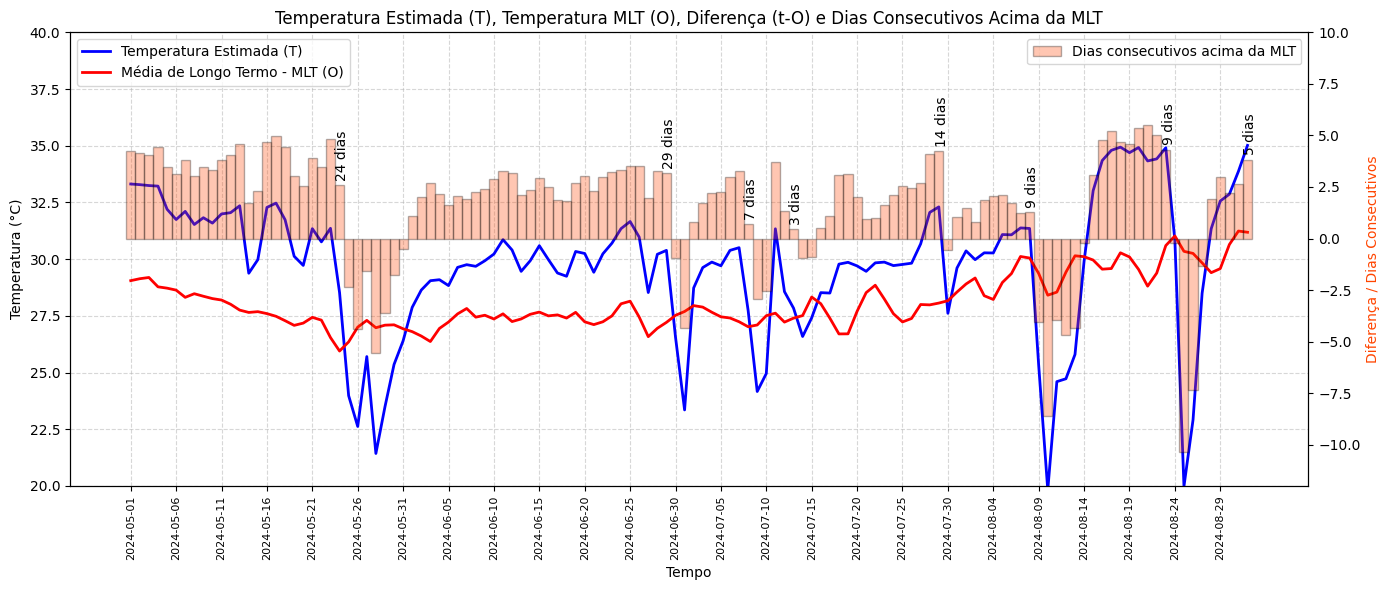

In [13]:
dt = ds_sp['time']
tp = ds_sp['tmax'].mean(axis=[1,2]).values
tp_mlt = ds_sp_mlt['ttmax'].mean(axis=[1,2]).values


# Calcular diferença
diff = tp - tp_mlt

# Contador de dias consecutivos e identificação do último dia da sequência
consec_days = np.zeros_like(tp, dtype=int)
end_of_sequence = np.zeros_like(tp, dtype=bool)

contador = 0
for i in range(len(tp)):
    end_of_sequence[i] = False
    if tp[i] > tp_mlt[i]:
        contador += 1
        # Se for o último dia ou o próximo (i+1) for menor/igual, marca como fim para criar máscara de onde plotar apenas osvalores que antecedem diferenças negativas
        if i == len(tp) - 1 or tp[i+1] <= tp_mlt[i+1]:
            end_of_sequence[i] = True
    else:
        contador = 0
    consec_days[i] = contador

# Plot principal
fig, ax1 = plt.subplots(figsize=(14, 6))

# Linhas principais
ax1.plot(dt, tp, color='blue', label='Temperatura Estimada (T)', linewidth=2)
ax1.plot(dt, tp_mlt, color='red', label='Média de Longo Termo - MLT (O)', linewidth=2)

# Barras: diferença no final de cada sequência
ax2 = ax1.twinx()

bars = ax2.bar(dt, diff, width=1.0, color='orangered', alpha=0.3,
               label='Dias consecutivos acima da MLT', edgecolor='black')

ax1.set_ylim(20, 40) 
ax2.set_ylim(-12, 10) 

# Adicionar texto com número de dias acima de cada barra
i = 0
for bar, count in zip(bars, consec_days):
    height = bar.get_height()
    if end_of_sequence[i]:
        ax2.text(
            bar.get_x() + bar.get_width()/2.+0.3,  # Centraliza o texto
            height + 0.2,                      # Um pouco acima da barra
            f'{count} dia{"s" if count > 1 else ""}',
            ha='center',
            va='bottom',
            fontsize=10,
            rotation='vertical'
        )
    i = i + 1

# Formatação do eixo X
dates = pd.to_datetime(dt)
formatted_labels = dates.strftime('%Y-%m-%d')
ax1.set_xticks(dates[::5])  # Intervalo ajustável
ax1.set_xticklabels(formatted_labels[::5], rotation=90, fontsize=8)

# Labels e títulos
ax1.set_xlabel('Tempo')
ax1.set_ylabel('Temperatura (°C)')
ax2.set_ylabel('Diferença / Dias Consecutivos', color='orangered')
ax1.set_title('Temperatura Estimada (T), Temperatura MLT (O), Diferença (t-O) e Dias Consecutivos Acima da MLT')

# Grade e layout
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()